# MNIST

Fetch MNIST Dataset

In [2]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame=False)

mnist.keys()

/home/kratosgado/anaconda3/lib/python3.11/site-packages/sklearn/datasets/_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [4]:
y.shape

(70000,)

reshape instance's feature vector to 28x28 array and display it

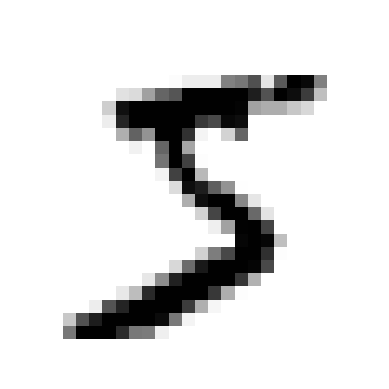

In [5]:
import matplotlib as mpl 
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap= mpl.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

In [6]:
y[0]

'5'

In [7]:
import numpy as np
y = y.astype(np.uint8)

split train set

In [8]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

Training a Binary Classifier

In [9]:
y_train_5 = (y_train == 5) # True for all 5s, False for all other digits
y_test_5 = (y_test == 5)

### SGDClassifier

In [10]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [11]:
sgd_clf.predict([some_digit])

array([ True])

#### Measuring Accuracy Using Cross-Validation

In [12]:
# custom cross-validation
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3)

for train_index, test_index in skfolds.split(X_train, y_train_5):
   clone_clf = clone(sgd_clf)
   X_train_folds = X_train[train_index]
   y_train_folds = y_train_5[train_index]
   X_test_fold = X_train[test_index]
   y_test_fold = y_train_5[test_index]

   clone_clf.fit(X_train_folds, y_train_folds)
   y_pred = clone_clf.predict(X_test_fold)
   n_correct = sum(y_pred == y_test_fold)
   print(n_correct / len(y_pred)) 

0.95035
0.96035
0.9604


In [13]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=5, scoring="accuracy")

array([0.95466667, 0.96975   , 0.9635    , 0.96533333, 0.94841667])

In [14]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
   
   def fit(self, X, y=None):
      pass

   def predict(self, X):
      return np.zeros((len(X), 1), dtype=bool)
   
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=5, scoring="accuracy")

array([0.91266667, 0.90866667, 0.9095    , 0.90883333, 0.90858333])

In [15]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=5)

get confusion matrix

In [16]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53115,  1464],
       [  916,  4505]])

In [17]:
y_train_perfect_predictions  = y_train_5 # pretend we reached perfection
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

### Precision and Recall

In [18]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.7547327860613168

In [19]:
recall_score(y_train_5, y_train_pred)

0.8310274857037447

Harmonic Mean(F1 Score)

In [20]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.791044776119403

## Precision/Recall Tradeoff

In [21]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [22]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [23]:
threshold = 8000 # raise threshold
y_some_digit_pred = y_scores > threshold
y_some_digit_pred

array([False])

In [24]:
y_scores = cross_val_predict(sgd_clf, X_train,y_train_5, cv=3, method="decision_function")

In [25]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

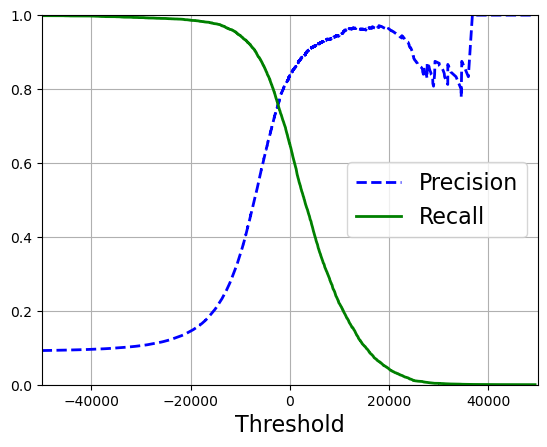

In [26]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-50000, 50000, 0, 1])             # Not shown

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [27]:
# aiming for 90% precision
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

In [28]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [29]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [30]:
recall_score(y_train_5, y_train_pred_90)


0.4799852425751706

## ROC Curve

In [31]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

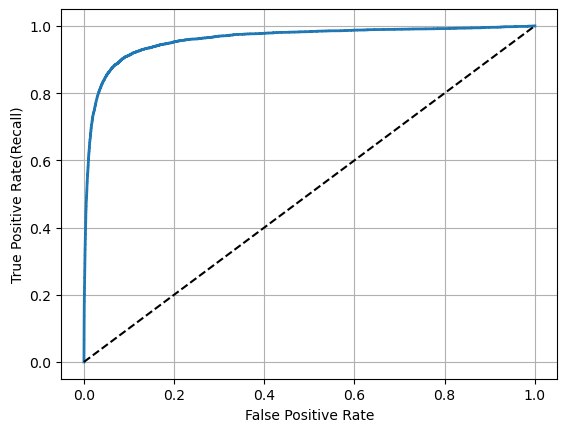

In [32]:
def plot_roc_curve(fpr, tpr, label=None):
   plt.plot(fpr, tpr, linewidth=2, label=label)
   plt.plot([0,1], [0,1], 'k--') # dashed diagonal
   plt.xlabel("False Positive Rate")
   plt.ylabel("True Positive Rate(Recall)")
   plt.grid(True)

plot_roc_curve(fpr, tpr)
plt.show()

compare classifier
NOTE: A perfect classifier has ROC AUC equal to 1, a random one has 0.5

In [33]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

## Random Forest Classifier

In [34]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=5, method="predict_proba")

In [35]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

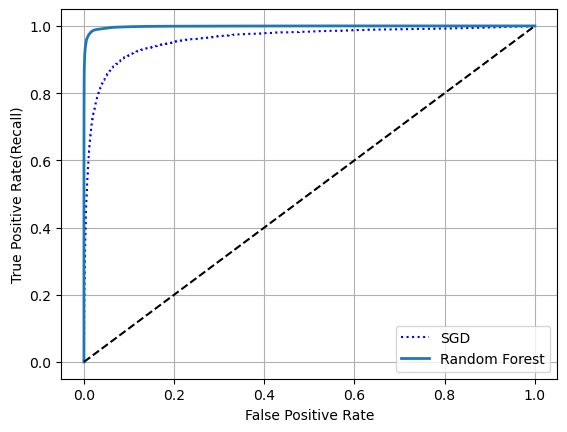

In [36]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [37]:
roc_auc_score(y_train_5, y_scores_forest)

0.998402186461512

In [38]:
precisions_forest, recalls_forest, threshold_forest = precision_recall_curve(y_train_5, y_scores_forest)

# Multiclass Classification

In [39]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [40]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [41]:
np.argmax(some_digit_scores)

3

In [42]:
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [43]:
sgd_clf.classes_[5]

5

Specifying OvO or OvA

In [44]:
from sklearn.multiclass import OneVsOneClassifier

ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([5], dtype=uint8)

In [45]:
len(ovo_clf.estimators_)

45

## Training RandomForestClassifier

In [46]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([5], dtype=uint8)

In [47]:
forest_clf.predict_proba([some_digit])

array([[0.  , 0.  , 0.01, 0.08, 0.  , 0.9 , 0.  , 0.  , 0.  , 0.01]])

## Cross Validating Multiclass classifiers

In [48]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [49]:
# scaling inputs
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

## Error Analysis

find confusion matrix

In [50]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

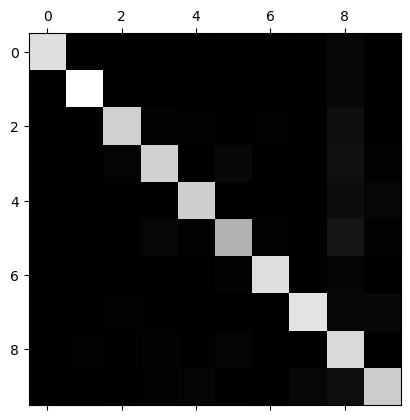

In [51]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

analyze confusion matrix

In [52]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx  = conf_mx/ row_sums

fill the diagonal with zeros to keep only the errors

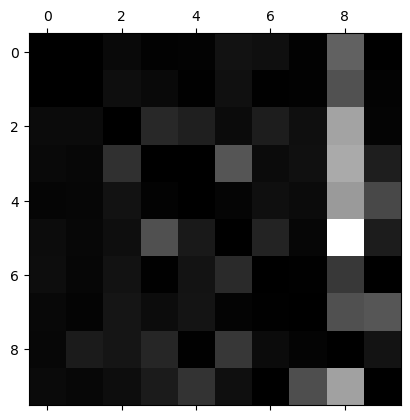

In [53]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap = plt.cm.gray )
plt.show()

In [55]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [56]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # This is equivalent to n_rows = ceil(len(instances) / images_per_row):
    n_rows = (len(instances) - 1) // images_per_row + 1

    # Append empty images to fill the end of the grid, if needed:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # Reshape the array so it's organized as a grid containing 28×28 images:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # Combine axes 0 and 2 (vertical image grid axis, and vertical image axis),
    # and axes 1 and 3 (horizontal axes). We first need to move the axes that we
    # want to combine next to each other, using transpose(), and only then we
    # can reshape:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # Now that we have a big image, we just need to show it:
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

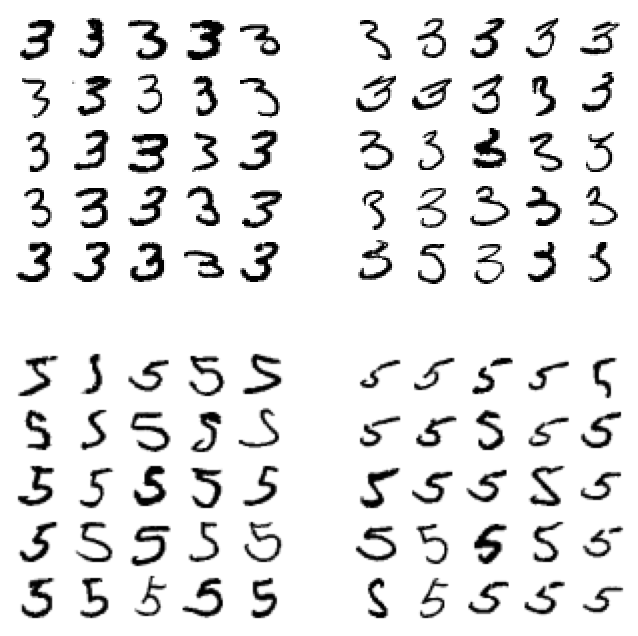

In [57]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

## Multilabel Classification

In [58]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [59]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [60]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976410265560605

## Multioutput Classification

noise images

In [61]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

view noise image

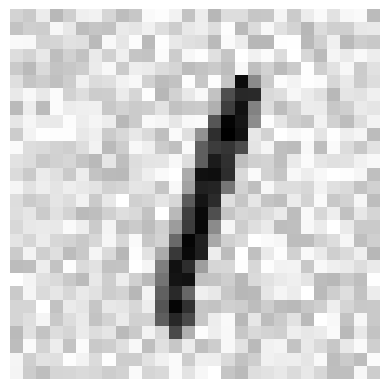

In [64]:
noise_image = X_test_mod[5]
plot_digit(noise_image)

In [66]:
knn_clf.fit(X_train_mod, y_train_mod)


KNeighborsClassifier()

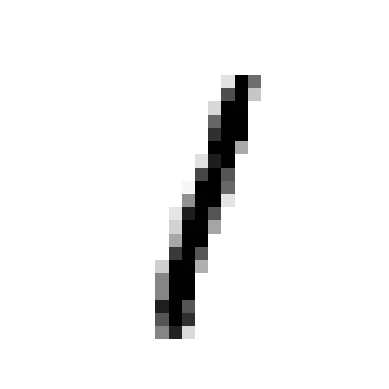

In [67]:
clean_digit = knn_clf.predict([X_test_mod[5]])
plot_digit(clean_digit)